# Microcanonical Molecular Dynamics Simulation
Velocity Verlet Algorithm; created 07/09/24

#### References
- D. Frenkel and B. Smit, *Understanding Molecular Simulation*, Academic Press, 2002.
- [Intro to Molecular Dynamics: Coding MD From Scratch](https://youtu.be/ChQbBqndwIA?si=d8QpMox3vhjQYxJm): Helpful for laying out the steps intuitively

In [ ]:
"""

Work In Progress

- Better visualisation
- Fix energy conservation
- Fix notes on formulas - out of date
- Documentation

"""

#### Goals:
- Implement a molecular dynamics simulation (velocity Verlet Algorithm) using the Lennard-Jones potential.
- Implement periodic boundary conditions.
- Create an animation visualising the particles.
- Simulate a bulk liquid, and create a figure of the radial distribution function.

#### Additional goals:
- Testing with other algorithms (e.g. Leap Frog) and ensembles.
- Testing with molecules and including other force field terms.
- Compute other thermodynamic properties: temperature, pressure, heat capacity (Ch 4.4 F&S).
- Calculate statistical error (pg 98 F&S).
- Parallelisation

## Libraries

In [77]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import random
#from matplotlib.animation import FuncAnimation
#from mpl_toolkits import mplot3d
#import pylab as pl
#from IPython import display

## Initial Parameters
All are in reduced units.

In [185]:
# Particle Parameters
m = 1 # Mass of particles
eps = 1 #epsilon
sig = 1 #sigma

# Initial Parameters
steps = 2500 # Time steps
N = 100 # Number of particles
L = 5 # Side of box
rc = 2.5*sig #Cut off radius for interactions
dt = 0.01 
T = 1 # Initial Temperature

# Constants
kb = 1

ecut = 4*eps*((sig/rc)**12 - (sig/rc)**6) # Potential at the cutoff; r = rc


## Functions
- length: Distance between two particles taking into account the minimum image convention.
- LJ: Potential energy of a particle as a sum of its pair-wise Lennard-Jones interactions.
- force: Components of force due to Lennard-Jones interactions.
- update: Updates the position, velocity, and acceleration of each particle after a single time step.
- energy: Returns the energy of the system as the sum of potential energy (LJ) and kinetic energy.

In [186]:
def length(position):
    """
    Returns the distance r_ij of closest images between each pair of particles as an N X N matrix.

    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray of floats, N x N
        Distance between particles as a matrix Y, where Y[1,2] is the closest image distance between particle 1 and 2.
    """

    Y = np.zeros((N, N))
    diff = np.zeros((N, N, 3))

    for i in range(N):
        diff[i] = position[i] - position #diff[i] is the difference in x/y/z coords of particle i to all other particles
        diff[i] = diff[i] - L*np.round(diff[i]/L, decimals=0) # difference between nearest image
        Y[i] = np.linalg.norm(diff[i], axis=1)

    return diff, Y


In [187]:
#Energy and force using Lennard-Jones

def LJ(epsilon, sigma, position):
    """
    Returns the total Lennard-Jones potential energy of the system.
    
    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.
    
    Returns
    -------
    ndarry of floats, N x 1
        Total potential energy of each particle.
    """

    LJ_array = np.zeros((N,3))
    coord, dist = length(position)
    dist[dist>rc] = 0 # Sets potential to those with distances creater than rc to be 0 (truncate)

    with np.errstate(divide='ignore', invalid='ignore'):
        a = (sigma/dist)**12
        b = (sigma/dist)**6
        LJ_array = 4*epsilon*(a - b) - ecut # Shifts potential
        LJ_array[LJ_array == np.inf] = 0
        LJ_array = np.nan_to_num(LJ_array)

    return np.sum(LJ_array)


def force(epsilon, sigma, position):
    """
    Returns the force due to the Lennard-Jones potential of each particle.
    
    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.
    
    Returns
    -------
    ndarray of floats, N x 3
        x, y, z component of force on each particle as a result of the pair-wise interactions.
    """

    force_array = np.zeros((N,N,3))
    a1, a2 = length(position)

    for i in range(N):
        for j in range(N):
            coord = a1[i,j]
            dist = a2[i][j]
            if abs(dist) < rc:
                with np.errstate(divide='ignore', invalid='ignore'):
                    a = (sigma/dist)**12
                    b = (sigma/dist)**6
                    force_array[i][j] = ((48*epsilon*coord)/(dist**2))*(a - 0.5*b)
                    force_array[i][j][force_array[i][j] == np.inf] = 0
                    force_array[i][j] = np.nan_to_num(force_array[i][j])
    
    force_array = np.sum(force_array, axis=1)

    return force_array

In [188]:
def update(position, velocity, acceleration, delta):
    """
    Returns the updated positions, velocities, and accelerations of the particles after one time step.
    
    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.

    acceleration: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray of 3 ndarrys of floats
        Updated arrays of position, velocity, and acceleration of each particle.
    """
    new_r = (position + delta*velocity + 0.5*acceleration*delta**2) % L
    new_a = force(eps, sig, new_r)/m
    new_v = velocity + 0.5*delta*(acceleration + new_a)
    return new_r, new_v, new_a

In [189]:
def energy(epsilon, sigma, position, velocity):
    """
    Returns the energy of the system (potential, kinetic).

    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.
    
    Returns
    -------
    float
        Total energy of the system.
    """
    
    pot = LJ(epsilon, sigma, position)
    kin = 0.5*m*np.sum(velocity**2)
    
    return pot, kin

#### OVITO
Visualisation software. Code below creates a directory named "dumps" which stores the data files generated.
- molecule labels: atoms are named from 0 to N-1.
- types: the colour it appears as (group).
- dump function: generates data file as t*.dump

In [190]:
#Print files for OVITO

outdir="dumps"
try: #make directory if it does not exist
    os.mkdir(outdir)
except:
    pass

#Types in groups of three
tp=[0]*N
for i in range(int(N/3)):
    tp[3*i]=0
    tp[3*i+1]=0
    tp[3*i+2]=0

#dump
def dump(r,t):
    fname=outdir+"/t"+str(t)+".dump"
    f=open(fname,"w")
    f.write("ITEM: TIMESTEP\n")
    f.write(str(t)+"\n") #time step
    f.write("ITEM: NUMBER OF ATOMS\n")
    f.write(str(len(r))+"\n") # number of atoms
    f.write("ITEM: BOX BOUNDS pp pp pp\n") #pp = periodic BCs
    f.write("0 "+str(L)+"\n")
    f.write("0 "+str(L)+"\n")
    f.write("0 "+str(L)+"\n")
    f.write("ITEM: ATOMS id x y z\n")
    for i in range(len(r)):
        f.write(str(i)+" "+str(r[i][0])+" "+str(r[i][1])+" "+str(r[i][2])+"\n")
    f.close

## Initialisation

In [191]:
#Initial conditions


r = set() # Allows each particle to be 1 apart whilst preventing duplicates
while len(r) < N:
    p = (random.randint(0, L-1), random.randint(0, L-1), random.randint(0, L-1))
    if p not in r:
        r.add(p)

r = np.array(list(r))
v = np.random.rand(N, 3) - 0.5 #Random velocities between -0.5 and 0.5

a = force(eps, sig, r)/m # Initial acceleration


In [192]:
# Scaling velocities to initial temperature

v_com = np.sum(v,axis=0)/N # velocity centre of mass
v = v - v_com

U, KE = energy(eps, sig, r, v)

temp = 2*KE/(3*N*kb) # Instantaneous T of system; F&S Eq 4.2.2; Factor of 2 is due to KE being 0.5 mv^2
sf = np.sqrt(T/temp)

v = sf*v # Sets centre of mass to be 0, and scales v to be that of set temp.

In [193]:
print(r)
print(v)
print(a)

[[4 0 1]
 [3 2 1]
 [4 1 2]
 [1 0 1]
 [1 1 0]
 [0 2 4]
 [2 0 1]
 [4 0 3]
 [4 2 0]
 [4 4 3]
 [3 3 4]
 [4 3 1]
 [0 0 0]
 [2 0 3]
 [4 2 2]
 [0 1 1]
 [3 1 0]
 [1 3 4]
 [1 4 3]
 [2 4 0]
 [1 1 4]
 [4 2 4]
 [0 3 0]
 [3 1 2]
 [2 4 2]
 [0 0 4]
 [0 2 1]
 [0 4 4]
 [4 0 0]
 [2 2 4]
 [4 4 0]
 [1 2 1]
 [3 1 4]
 [3 0 1]
 [3 2 3]
 [3 3 1]
 [1 0 3]
 [2 0 0]
 [4 0 2]
 [2 1 1]
 [4 4 2]
 [1 3 1]
 [1 2 3]
 [1 4 0]
 [3 3 3]
 [3 4 2]
 [2 3 1]
 [4 3 3]
 [2 0 2]
 [4 0 4]
 [0 1 0]
 [2 1 3]
 [4 4 4]
 [1 3 3]
 [1 4 2]
 [3 4 4]
 [0 0 1]
 [2 3 3]
 [3 0 0]
 [3 1 1]
 [3 2 0]
 [1 4 4]
 [0 0 3]
 [0 2 0]
 [4 1 1]
 [1 0 0]
 [2 4 4]
 [0 4 3]
 [3 0 2]
 [1 2 0]
 [0 3 4]
 [3 2 2]
 [4 3 0]
 [1 0 2]
 [3 0 4]
 [4 4 1]
 [1 2 2]
 [3 2 4]
 [3 4 1]
 [2 3 0]
 [1 0 4]
 [1 1 3]
 [2 1 2]
 [2 0 4]
 [4 2 3]
 [0 1 2]
 [1 2 4]
 [1 4 1]
 [3 4 3]
 [2 3 2]
 [2 4 1]
 [4 3 4]
 [0 4 0]
 [2 1 4]
 [2 2 3]
 [0 1 4]
 [0 3 1]
 [2 4 3]
 [0 4 2]
 [0 2 2]]
[[ 3.97584855e-03 -4.75306063e-01  3.23457917e-01]
 [ 1.52099733e+00 -4.08325726e-01 -1.09257838e+0

## Running the Simulation

Progress: 99.96%

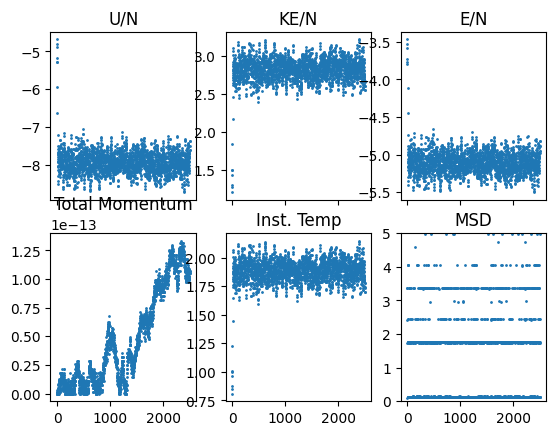

In [194]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=False)
axs = axs.ravel()

mom = np.empty((steps)) # Total momentum
kinetic = np.empty((steps))
potential = np.empty((steps))
E = np.empty((steps))
inst_temp = np.empty((steps))
MSD = np.empty((steps))
run = 1

if run==1:
    for i in range(steps):
        #dump(r,i)
        mom[i] = m*np.linalg.norm(np.sum(v))
        potential[i], kinetic[i] = energy(eps, sig, r, v)
        new_r, v, a = update(r,v,a,dt)
        MSD[i] = np.mean(np.linalg.norm(new_r-r, axis=0))
        r = new_r
        sys.stdout.write('\r')
        sys.stdout.write("Progress: {:.2%}".format(i/steps))
        sys.stdout.flush()

E = kinetic + potential
inst_temp = 2*kinetic/(3*N*kb)

axs[0].scatter(np.arange(steps), potential/N, label = "U", s=1)
axs[0].title.set_text("U/N")

axs[1].scatter(np.arange(steps), kinetic/N, label="KE", s=1)
axs[1].title.set_text("KE/N")

axs[2].scatter(np.arange(steps), E/N, label="Etot", s=1)
axs[2].title.set_text("E/N")

axs[3].scatter(np.arange(steps), mom,s=1)
axs[3].title.set_text("Total Momentum")

axs[4].scatter(np.arange(steps), inst_temp, label="Temp", s=1)
axs[4].title.set_text("Inst. Temp")

axs[5].scatter(np.arange(steps), MSD, label="MSD", s=1)
axs[5].title.set_text("MSD")
axs[5].set_ylim([0, L])

plt.show()